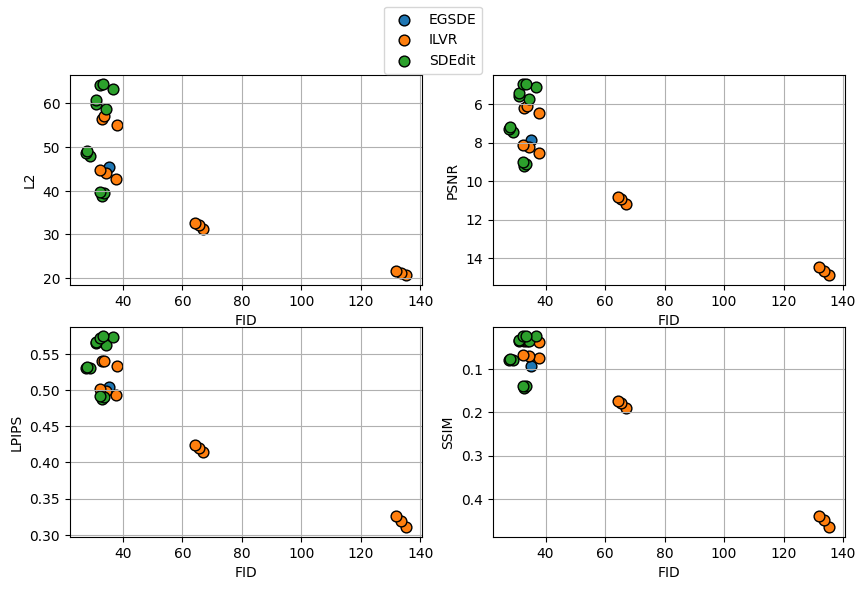

In [29]:
import json
from matplotlib import pyplot as plt

all_res = [('egsde_results.json', 'EGSDE'), ('ilvr_results.json', 'ILVR'), ('sdedit_results.json', 'SDEdit')]

fig, axs = plt.subplots(2, 2, figsize=(10, 6))


for res, name in all_res:
    with open(res) as f:
        d = json.load(f)
        all_fid, all_l2, all_lpips, all_ssim, all_psnr = [], [], [], [], []
        
        for k, v in d.items():
            all_fid.append(v['FID'])
            all_ssim.append(v['SSIM'])
            all_l2.append(v['L2'])
            all_lpips.append(v['LPIPS'])
            all_psnr.append(v['PSNR'])
            
        axs[0, 0].scatter(all_fid, all_l2, s=60, label=name, edgecolors='black')
        axs[0, 1].scatter(all_fid, all_psnr, s=60, label=name, edgecolors='black')
        axs[1, 0].scatter(all_fid, all_lpips, s=60, label=name, edgecolors='black')
        axs[1, 1].scatter(all_fid, all_ssim, s=60, label=name, edgecolors='black')

# high-quality code
axs[0, 0].set_xlabel('FID')
axs[0, 1].set_xlabel('FID')
axs[1, 0].set_xlabel('FID')
axs[1, 1].set_xlabel('FID')

axs[0, 0].set_ylabel('L2')
axs[0, 1].set_ylabel('PSNR')
axs[1, 0].set_ylabel('LPIPS')
axs[1, 1].set_ylabel('SSIM')

axs[0, 0].grid()
axs[0, 1].grid()
axs[1, 0].grid()
axs[1, 1].grid()

axs[0, 1].set_ylim(axs[0,1].get_ylim()[::-1])
axs[1, 1].set_ylim(axs[1,1].get_ylim()[::-1])

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

In [30]:
%cd guided-diffusion
from guided_diffusion.unet import EncoderUNetModel
from guided_diffusion.nn import timestep_embedding
%cd ..

class EGClassifier(EncoderUNetModel):
    def forward(self, x, timesteps):
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
        res = self.middle_block(h, emb)
        h_res = res.type(x.dtype)
        return res, self.out(h_res)


/home/jupyter/work/resources/guided-diffusion
/home/jupyter/work/resources


In [31]:
class_model = EGClassifier(image_size=64,
                           in_channels=3,
                           out_channels=1000,
                           model_channels=128,
                           channel_mult=(1,2,3,4),
                           attention_resolutions=[32, 16, 8],
                           use_scale_shift_norm=True,
                           resblock_updown=True,
                           num_res_blocks=4,
                           num_head_channels=64,
                           pool='attention'
                           )

In [32]:
import torch
import torch.nn as nn

pretrained_dict = torch.load('64x64_classifier.pt', map_location="cuda")
model_dict = class_model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
class_model.load_state_dict(model_dict, strict=False)

class_model.out[2].c_proj = nn.Conv1d(512, 2,  kernel_size=(1,), stride=(1,))

In [33]:
pretrained_class = torch.load('checkpoints/checkpoint_epoch_9', map_location="cuda")
class_model.load_state_dict(pretrained_class)

<All keys matched successfully>

In [34]:
from dataset import SourceImgDataset

dataset = SourceImgDataset('/home/jupyter/datasphere/project/edm/datasets/afhqv2-64x64', lbl_val=0)

In [36]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=6, shuffle=True)

In [37]:
%cd edm
from dnnlib import util
import torch_utils
%cd ..
import pickle

device = 'cuda:0'
with util.open_url('wild64.pkl') as f:
    net = pickle.load(f)['ema'].to(device)

/home/jupyter/work/resources/edm
/home/jupyter/work/resources


In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    axs[0, 0].set_xlabel('Original')
    axs[0, 1].set_xlabel('SDEdit')
    axs[0, 2].set_xlabel('ILVR')
    axs[0, 3].set_xlabel('EGSDE')

  0%|          | 0/927 [00:00<?, ?it/s]

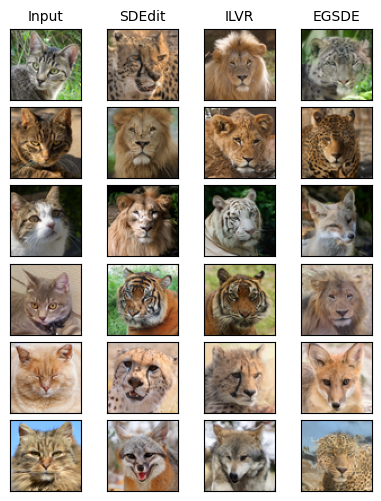

  0%|          | 0/927 [00:31<?, ?it/s]


In [85]:
from i2i_methods import egsde, ilvr, sdedit
from matplotlib import pyplot as plt
import torch 
from tqdm import tqdm
import torchvision


sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 10.0,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 1,
    'stochastic': False,
    'cfg': 0,
    'l_1': 2,
    'l_2': 500,
    'class_model': class_model,
    'scale_factor': 32,
}

net.eval()
for img_src in tqdm(train_loader):
    img_src = img_src.to(device)
    
    sampling_params['num_steps'] = 50
    res_eg = egsde(net, img_src, sampling_params)
    
    sampling_params['num_steps'] = 50
    res_sd = sdedit(net, img_src, sampling_params)
    
    sampling_params['scale_factor'] = 16
    sampling_params['num_steps'] = 32
    sampling_params['sigma_max'] = 80.0
    res_il = ilvr(net, img_src, sampling_params)
    
    res_eg = (res_eg * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
    res_sd = (res_sd * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
    res_il = (res_il*  127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
    img_src = (img_src * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
    
    fig, axs = plt.subplots(6, 4, squeeze=False, figsize=(10, 6))
    for i in range(6):
        axs[i, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[i, 1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[i, 2].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[i, 3].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
        axs[i, 0].set_aspect('equal')
        axs[i, 1].set_aspect('equal')
        axs[i, 2].set_aspect('equal')
        axs[i, 3].set_aspect('equal')
        
        axs[i, 0].imshow(img_src[i])
        axs[i, 1].imshow(res_eg[i])
        axs[i, 2].imshow(res_sd[i])
        axs[i, 3].imshow(res_il[i])
        
    axs[0, 0].set_title('Input')
    axs[0, 1].set_title('SDEdit')
    axs[0, 2].set_title('ILVR')
    axs[0, 3].set_title('EGSDE')
    
    axs[0, 0].title.set_size(10)
    axs[0, 1].title.set_size(10)
    axs[0, 2].title.set_size(10)
    axs[0, 3].title.set_size(10)
    
    plt.subplots_adjust(wspace=-0.8, hspace=0.1)
    plt.show()
    break